In [3]:
using Distributions
using Random
using Plots

In [4]:
p = [0.1, 0.9]

2-element Array{Float64,1}:
 0.1
 0.9

In [5]:
m = Multinomial(32, p)

Multinomial{Float64}(n=32, p=[0.1, 0.9])

In [15]:
srand(9636)

UndefVarError: UndefVarError: srand not defined

In [16]:
rand(m, 3)

2×3 Array{Int64,2}:
  5   6   3
 27  26  29

In [17]:
function draw_dirichlet_multinomial(n::Int64, α::Vector{Float64}, T::Real, K::Int64)
    p = rand(Dirichlet(T * α ./ sum(α, dims=1)), K)
    Xk = zeros(Int64, size(p))
    for k = 1:K
        Xk[:,k] = rand(Multinomial(n, p[:,k]))
    end
    return Xk
end

draw_dirichlet_multinomial (generic function with 1 method)

In [57]:
K = 3
p = [0.7, 0.2, 0.1]
T = 100
Xk = draw_dirichlet_multinomial(10, p, T, 1000)

3×1000 Array{Int64,2}:
 8  7  7  8  7  8  5  8  8  8  4  6  8  …  8  2  7  7  8  5  6  7  6  7  6  8
 2  0  2  2  1  1  1  2  1  2  5  1  2     1  5  0  3  1  3  2  2  3  1  4  2
 0  3  1  0  2  1  4  0  1  0  1  3  0     1  3  3  0  1  2  2  1  1  2  0  0

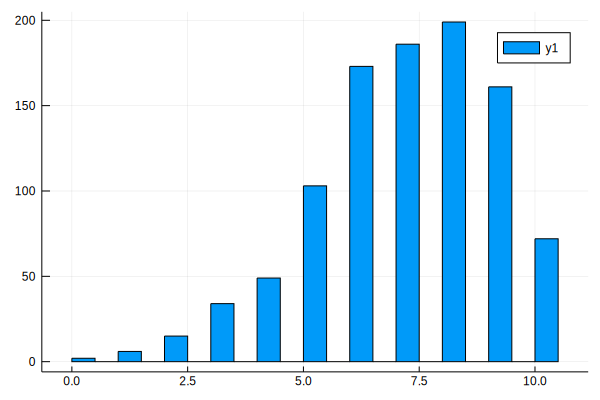

In [52]:
histogram(Xk[1,:])

In [53]:
function compute_KLD(Xk::Array{Int64,2}, p::Vector{Float64})
    share = Xk ./ sum(Xk, dims=1)
    deviation = log.(share ./ p)
    # log(0) is fine because 0*log(0) = 0
    replace!(deviation, -Inf=>0)
    # convert to vector instead of 1xK array
    return vec(sum(share .* deviation, dims=1))
end

compute_KLD (generic function with 1 method)

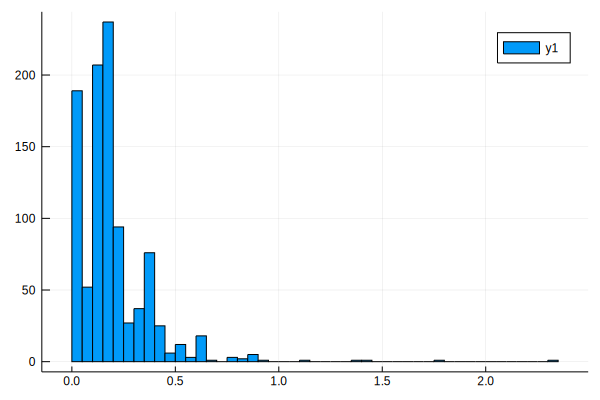

In [54]:
KLD = compute_KLD(Xk, p)
histogram(KLD)

In [55]:
KLD

1000-element Array{Float64,1}:
 0.22618298545281557
 0.15686826739682103
 0.10682511409961822
 0.10682511409961822
 0.0
 0.32958368660043286
 0.09203285023383187
 0.22618298545281557
 0.03751039604362369
 0.22618298545281557
 0.10682511409961822
 0.3526532007082499
 0.04613902821563412
 ⋮
 0.0
 0.03751039604362369
 0.3566749439387324
 0.22618298545281557
 0.1613475682898264
 0.1613475682898264
 0.2273769038587131
 0.23429905076290852
 0.22618298545281557
 0.40497801508470466
 0.06931471805599453
 0.0

In [49]:
function iterate_dirichlet_multinomial_MLE(nki::Array{Int64, 2}, αk::Vector{Float64})
    # K categories, sampled N times
    K, N = size(nki)
   
    ni = sum(nki, dims=1)
    α0 = sum(αk, dims=1)
    
    # use eq (65) from https://tminka.github.io/papers/dirichlet/minka-dirichlet.pdf
    return vec(αk .* sum(nki ./ (nki .+ αk .- 1), dims=2) ./ sum(ni ./ (ni .+ α0 .- 1), dims=2))
        
end
function estimate_dirichlet_multinomial(X)
    K, N = size(X)
    α = 2.0*ones(K)
    threshold = 1e-12
    distance = 1e+12
    
    while distance > threshold
        new_α = iterate_dirichlet_multinomial_MLE(X, α)
        distance = maximum(abs.(log.(α) .- log.(new_α)))
        α = new_α
    end
    return (α ./ sum(α), sum(α))
end

estimate_dirichlet_multinomial (generic function with 1 method)

In [58]:
αk, T = estimate_dirichlet_multinomial(Xk)

([0.7028503432970504, 0.2002862111009226, 0.09686344560202698], 85.43169288157287)

In [48]:
sum(αk)

10.120231207646542

In [34]:
Xk

3×1000 Array{Int64,2}:
 3  3  6  7  5  4  4  2  3  2  2  2  6  …  2  5  8  6  0  1  4  4  6  5  3  4
 5  1  3  2  4  4  3  2  2  5  4  2  4     5  3  0  1  5  6  4  4  4  1  3  4
 2  6  1  1  1  2  3  6  5  3  4  6  0     3  2  2  3  5  3  2  2  0  4  4  2